In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit, prange
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.optimize import root_scalar
import glob
import agama

from pyMND.forcetree import construct_tree, force_treeevaluate_loop

from rbf.interpolate import KNearestRBFInterpolant
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

time_conv = 977.79222167
G = 43018.7

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=None, 
              fields=['Coordinates', 'Masses', 'Velocities', 'Acceleration'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

In [6]:
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

In [7]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]])
    pos = np.swapaxes(pos, 0, 1)

    pos = np.matmul(Rmat, pos)
    
#     w[:3,:] = np.matmul(Rmat, w[:3,:])
#     w[3:,:] = np.matmul(Rmat, w[3:,:])

    pos = np.swapaxes(pos, 0, 1)
    return pos

# rotate by bar angle at each time step

def rotate_wlist(wlist, bar_angle_out, idx_list):
    bar_angle = np.mod(bar_angle_out['bar_angle'][idx_list], 2.*np.pi)

    Rwlist = np.zeros(np.shape(wlist))

    for i,idx in enumerate(idx_list):
        Rwlist[i] = rotate_w(wlist[i], -bar_angle[i])
    
    return Rwlist

In [ ]:
# read in the bar position
phase_space_path = '/n/home01/abeane/starbar/plots/phase_space/data'
in_bar_path = '/n/home01/abeane/starbar/plots/in_bar/data'
nchunk = len(glob.glob(phase_space_path + '/phantom-vacuum-Sg20-Rc3.5-lvl3/phase_space_*'))

pos0 = np.array([]).reshape((0, 3))
vel0 = np.array([]).reshape((0, 3))

pos1 = np.array([]).reshape((0, 3))
vel1 = np.array([]).reshape((0, 3))

posN0 = np.array([]).reshape((0, 3))
velN0 = np.array([]).reshape((0, 3))

posN1 = np.array([]).reshape((0, 3))
velN1 = np.array([]).reshape((0, 3))

in_bar0 = np.array([])
in_bar1 = np.array([])

in_barN0 = np.array([])
in_barN1 = np.array([])
center = np.array([200., 200., 200.])

idx0 = 250
idx1 = idx0 + 1

for i in tqdm(range(nchunk)):
    ps = h5.File(phase_space_path + '/phantom-vacuum-Sg20-Rc3.5-lvl3/phase_space_phantom-vacuum-Sg20-Rc3.5-lvl3.'+str(i)+'.hdf5',
                 mode='r')
    
    ib = h5.File(in_bar_path + '/in_bar_phantom-vacuum-Sg20-Rc3.5-lvl3/in_bar_phantom-vacuum-Sg20-Rc3.5-lvl3.'+str(i)+'.hdf5',
                 mode='r')

    pos0 = np.concatenate((pos0, ps['PartType2/Coordinates'][idx0,:,:]))
    pos0 = np.concatenate((pos0, ps['PartType3/Coordinates'][idx0,:,:]))
    pos0 = np.concatenate((pos0, ps['PartType4/Coordinates'][idx0,:,:]))
    
    pos1 = np.concatenate((pos1, ps['PartType2/Coordinates'][idx1,:,:]))
    pos1 = np.concatenate((pos1, ps['PartType3/Coordinates'][idx1,:,:]))
    pos1 = np.concatenate((pos1, ps['PartType4/Coordinates'][idx1,:,:]))
    
    vel0 = np.concatenate((vel0, ps['PartType2/Velocities'][idx0,:,:]))
    vel0 = np.concatenate((vel0, ps['PartType3/Velocities'][idx0,:,:]))
    vel0 = np.concatenate((vel0, ps['PartType4/Velocities'][idx0,:,:]))
    
    vel1 = np.concatenate((vel1, ps['PartType2/Velocities'][idx1,:,:]))
    vel1 = np.concatenate((vel1, ps['PartType3/Velocities'][idx1,:,:]))
    vel1 = np.concatenate((vel1, ps['PartType4/Velocities'][idx1,:,:]))
    
    in_bar0 = np.concatenate((in_bar0, ib['in_bar'][idx0]))
    in_bar1 = np.concatenate((in_bar1, ib['in_bar'][idx1]))
    
    bar_angle0 = ib['bar_angle'][idx0]
    bar_angle1 = ib['bar_angle'][idx1]
    
    ps.close()
    ib.close()

    ps = h5.File(phase_space_path + '/Nbody-lvl3/phase_space_Nbody-lvl3.'+str(i)+'.hdf5', mode='r')
    
    ib = h5.File(in_bar_path + '/in_bar_Nbody-lvl3/in_bar_Nbody-lvl3.'+str(i)+'.hdf5', mode='r')

    posN0 = np.concatenate((posN0, ps['PartType2/Coordinates'][idx0,:,:]))
    posN0 = np.concatenate((posN0, ps['PartType3/Coordinates'][idx0,:,:]))
    
    posN1 = np.concatenate((posN1, ps['PartType2/Coordinates'][idx1,:,:]))
    posN1 = np.concatenate((posN1, ps['PartType3/Coordinates'][idx1,:,:]))
    
    velN0 = np.concatenate((velN0, ps['PartType2/Velocities'][idx0,:,:]))
    velN0 = np.concatenate((velN0, ps['PartType3/Velocities'][idx0,:,:]))
    
    velN1 = np.concatenate((velN1, ps['PartType2/Velocities'][idx1,:,:]))
    velN1 = np.concatenate((velN1, ps['PartType3/Velocities'][idx1,:,:]))
    
    in_barN0 = np.concatenate((in_barN0, ib['in_bar'][idx0]))
    in_barN1 = np.concatenate((in_barN1, ib['in_bar'][idx1]))
    
    bar_angleN0 = ib['bar_angle'][idx0]
    bar_angleN1 = ib['bar_angle'][idx1]
    
    ps.close()
    ib.close()
    
pos0 = pos0 - center
pos0 = rotate_pos(pos0, -bar_angle0)
vel0 = rotate_pos(vel0, -bar_angle0)
pos1 = pos1 - center
pos1 = rotate_pos(pos1, -bar_angle1)
vel1 = rotate_pos(vel1, -bar_angle1)

posN0 = rotate_pos(posN0, -bar_angleN0)
posN1 = rotate_pos(posN1, -bar_angleN1)
velN0 = rotate_pos(velN0, -bar_angleN0)
velN1 = rotate_pos(velN1, -bar_angleN1)


    

A Jupyter Widget

In [27]:
left_bar = np.where(np.logical_and(in_barN0, np.logical_not(in_barN1)))[0]
join_bar = np.where(np.logical_and(np.logical_not(in_barN0), in_barN1))[0]

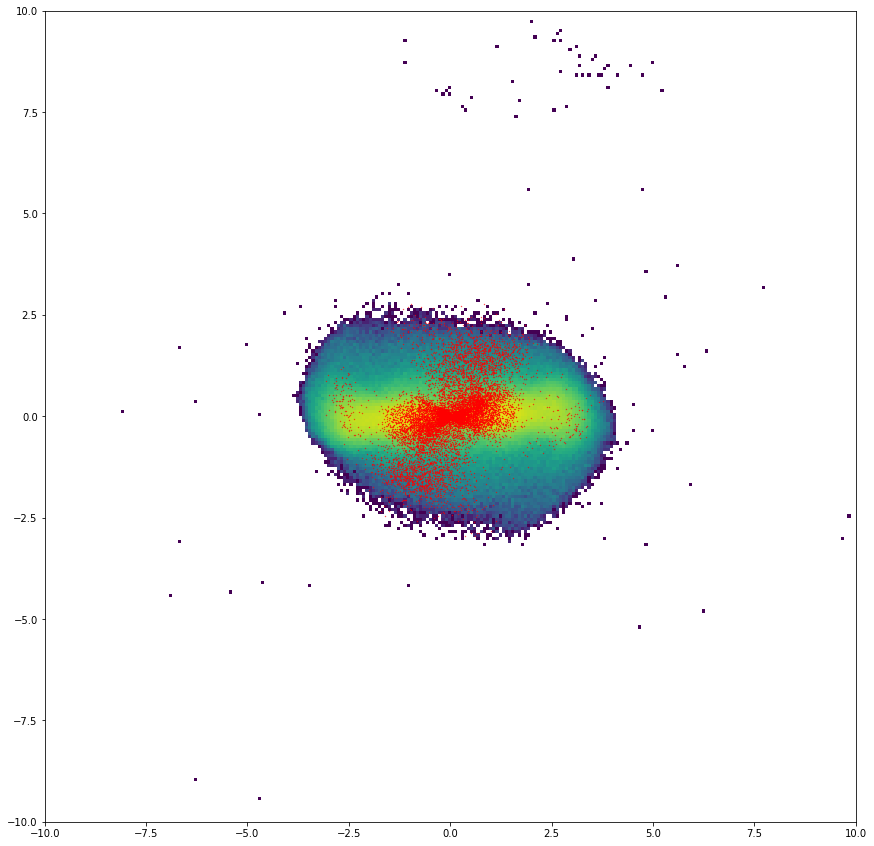

In [28]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = posN0[np.where(in_barN0)[0]][:,0]
y = posN0[np.where(in_barN0)[0]][:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.scatter(posN0[join_bar][:,0], posN0[join_bar][:,1], s=0.1, c='r')
ax.set_aspect('equal')
fig.tight_layout()

plt.show()
